## Perform the first step of the Two-step Engle-Granger Cointegration Test

We consider two series of equity prices $Y_{t}$ and $X_{t}$ as a time series conforming to the expression:
$$ Y_{t} = \alpha + \beta X_{t} + \epsilon_{t} $$, where $\alpha$ and $\beta$ are constants and are the outputs
of our regression model, the residuals are the differences between the modeled regression and the actual values.

0      -3.554273
1      -3.812871
2      -3.472871
3      -3.294551
4      -3.456310
          ...   
7795   -5.230583
7796   -5.267263
7797   -5.268943
7798   -5.160742
7799   -5.200781
Length: 7800, dtype: float64


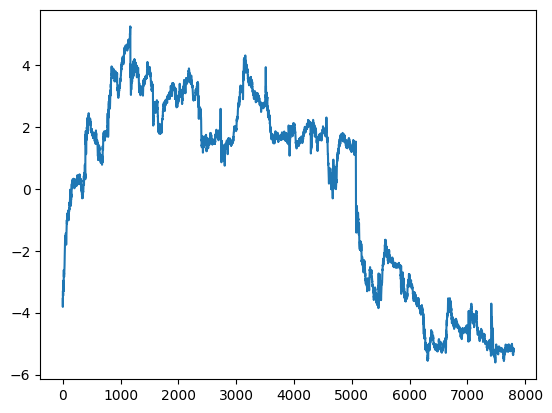

In [2]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

ko = pd.read_pickle('../data/ko.pkl')
pep = pd.read_pickle('../data/pep.pkl')

def regression_residuals(s1: pd.DataFrame, s2: pd.DataFrame) -> pd.DataFrame:
    x = s1[0]
    y = s2[0]

    # add a constant term
    x = sm.add_constant(x)

    model = sm.OLS(y, x)
    res = model.fit()

    return res.resid


residuals = regression_residuals(ko, pep)

print(residuals)

sns.lineplot(residuals)
plt.show()


## Performing the Dickey Fuller Test on the Time Series of Residuals

In [3]:
from statsmodels.tsa.stattools import adfuller

def adf_test() -> float:
    res = adfuller(residuals)
    print(res[1])


adf_test()

0.8894471963181498


In [5]:
# now we do the two step engle granger test on all pairs from the NASDAQ 100

import os
from tqdm.notebook import tqdm

DATA_BASE = '../data/nasdaq/'
unprobed_files = os.listdir(DATA_BASE)

# only include mature companies,
# also makes OLS simpler

files = []
for file in unprobed_files:
    file_path = os.path.join(DATA_BASE, file)
    df = pd.read_pickle(file_path)

    prices = df[0]
    if len(prices) != 2516:
        continue

    files.append(file)

p_values = {}
for i in tqdm(range(len(files)), desc="Running ADF Test"):
    base_file = files[i]
    base_file_path = os.path.join(DATA_BASE, base_file)
    base_df = pd.read_pickle(base_file_path)
    base_ticker = base_file.split('.')[0]

    base_p_values = []
    for j in range(len(files)):
        aux_file = files[j]
        aux_file_path = os.path.join(DATA_BASE, aux_file)
        aux_df = pd.read_pickle(aux_file_path)

        try:
            residuals = regression_residuals(base_df, aux_df)
            adf = adfuller(residuals)
            p_value = adf[1]
        except:
            print(f'error on base: {i}, aux: {j}')
            p_value = 1

        base_p_values.append(p_value)

    p_values[base_ticker] = base_p_values

# show sns heatmap
heatmap_index = list(map(lambda f: f.split('.')[0], files))

heatmap_df = pd.DataFrame(p_values, index=heatmap_index)
heatmap_df.to_pickle('../data/adf.pkl')

Running ADF Test:   0%|          | 0/79 [00:00<?, ?it/s]

error on base: 2, aux: 76
error on base: 4, aux: 49


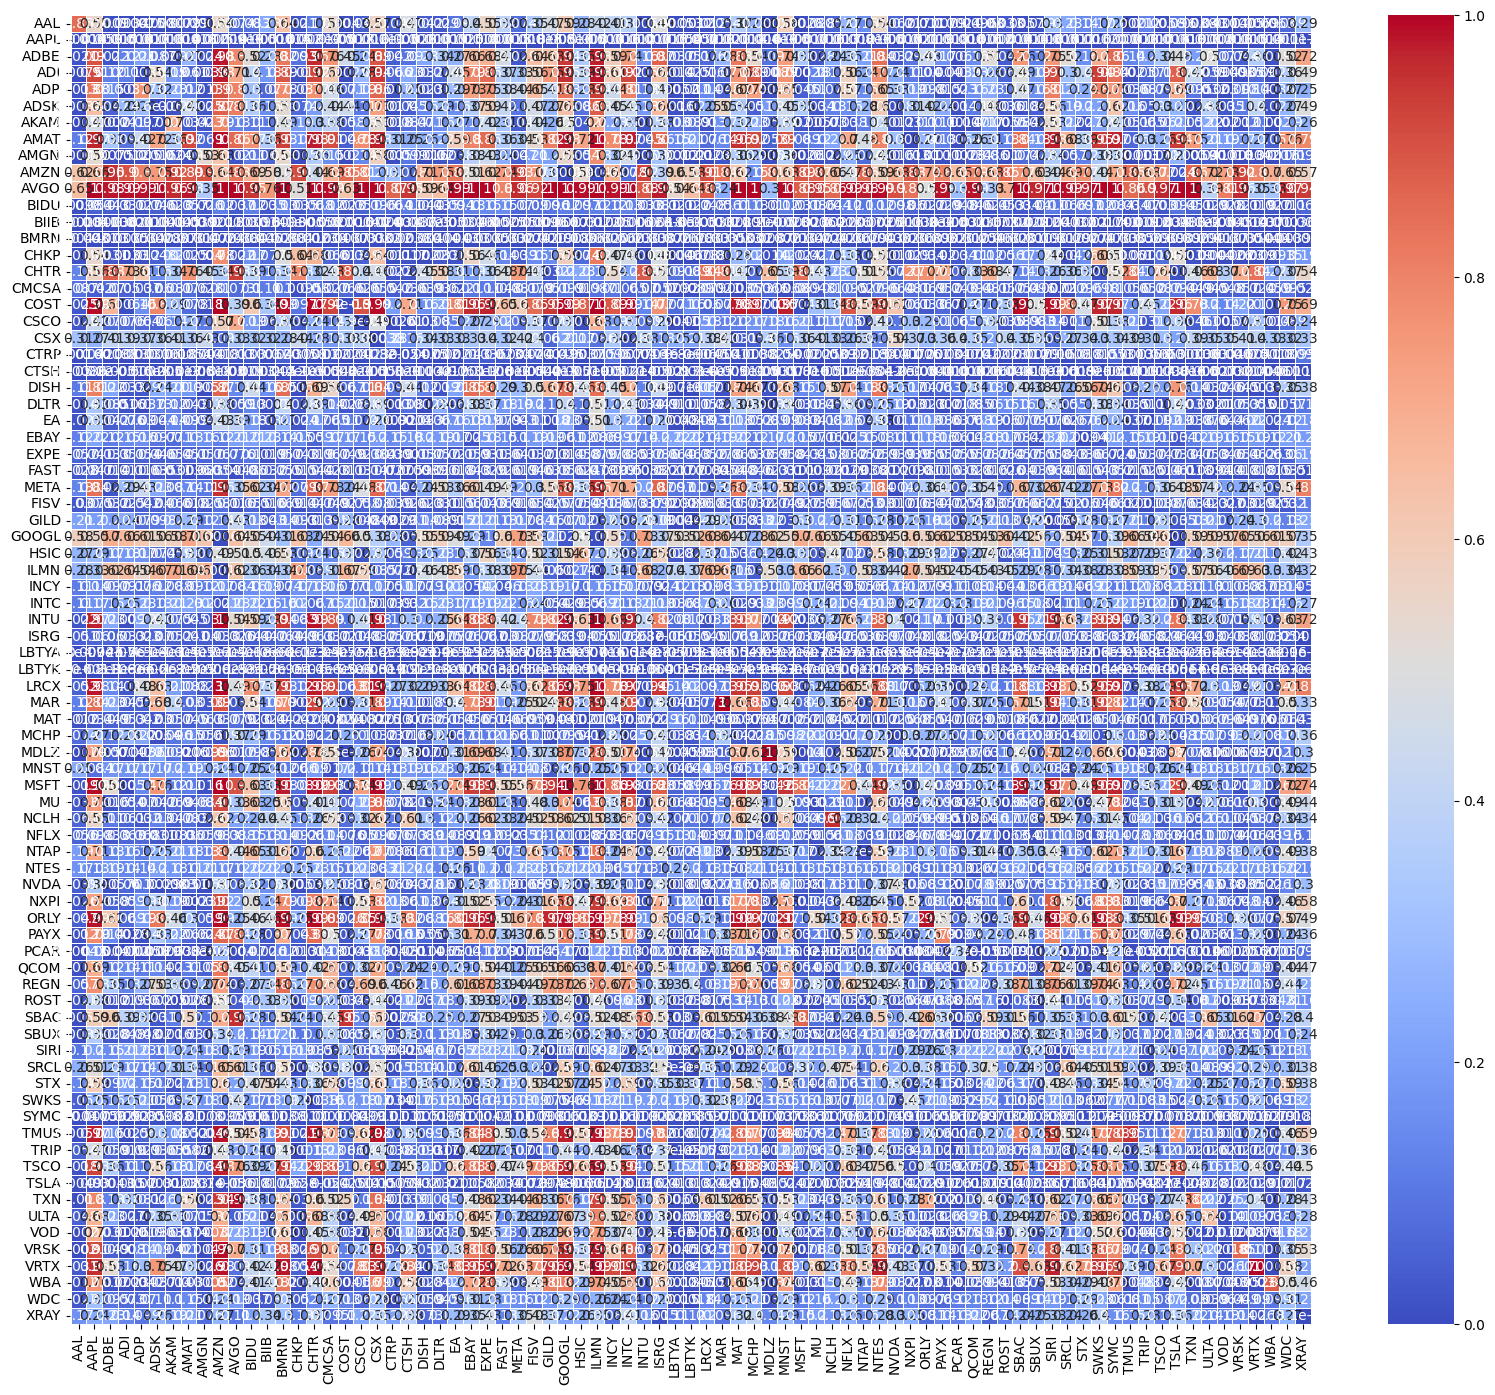

NameError: name 'regression_residuals' is not defined

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_df = pd.read_pickle('../data/adf.pkl')
heatmap_df = heatmap_df.iloc[:, :]

plt.figure(figsize=(20, 17))
sns.heatmap(heatmap_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

# cointegration of TSCO with TSCO
tsco = pd.read_pickle('../data/nasdaq/XRAY.pkl')
amzn = pd.read_pickle('../data/nasdaq/AAPL.pkl')
tsco_residuals = regression_residuals(tsco, amzn)

tsco_adf = adfuller(tsco_residuals)
print(tsco_adf[1])


100
['AAPL', 'XRAY', 9.104296439449678e-05]
['AAPL', 'WBA', 0.00011254543577701014]
['AAPL', 'VRTX', 0.00014280647279306093]
['AAPL', 'VRSK', 0.00015429781044445213]
['AMGN', 'WBA', 0.00016469559752946386]
['AAPL', 'TSCO', 0.00016489122300362627]
['AAPL', 'WDC', 0.0001652537550668745]
['AAPL', 'TSLA', 0.00017722866444703876]
['AMGN', 'VOD', 0.00018081206670114813]
['AAPL', 'TXN', 0.00018223283943511726]
['AAPL', 'VOD', 0.0001832551520982679]
['AAPL', 'ULTA', 0.00019959402295639163]
['AAL', 'VRSK', 0.0004991534973228208]
['AMGN', 'VRSK', 0.0012613877711685013]
['AAL', 'VOD', 0.001372289626259279]
['AKAM', 'WBA', 0.0019787271415533264]
['ADI', 'WBA', 0.002478094896890928]
['ADP', 'VOD', 0.003076304705833153]
['ADP', 'WBA', 0.003621121424164189]
['AMGN', 'VRTX', 0.004213161318149171]
['ADI', 'VOD', 0.004872499653992016]
['AAL', 'TSCO', 0.0057820161490327515]
['AMGN', 'TXN', 0.00586946796505711]
['AAL', 'WBA', 0.006302924171463096]
['AAL', 'VRTX', 0.0068597722288502895]
['ADI', 'VRSK', 0.0

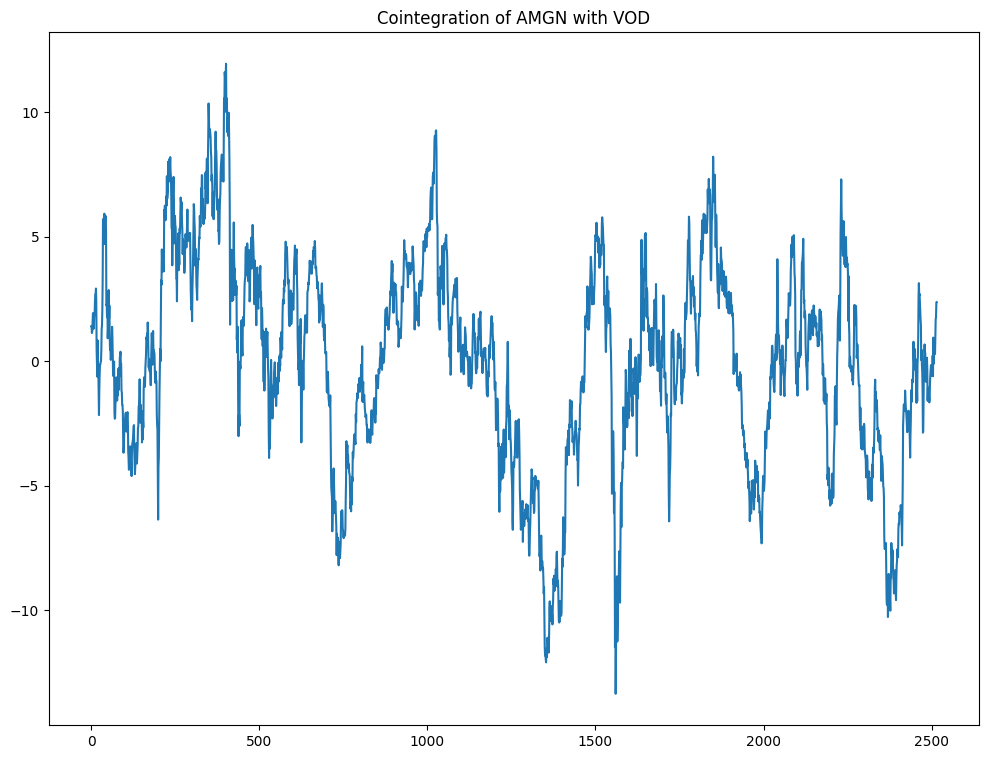

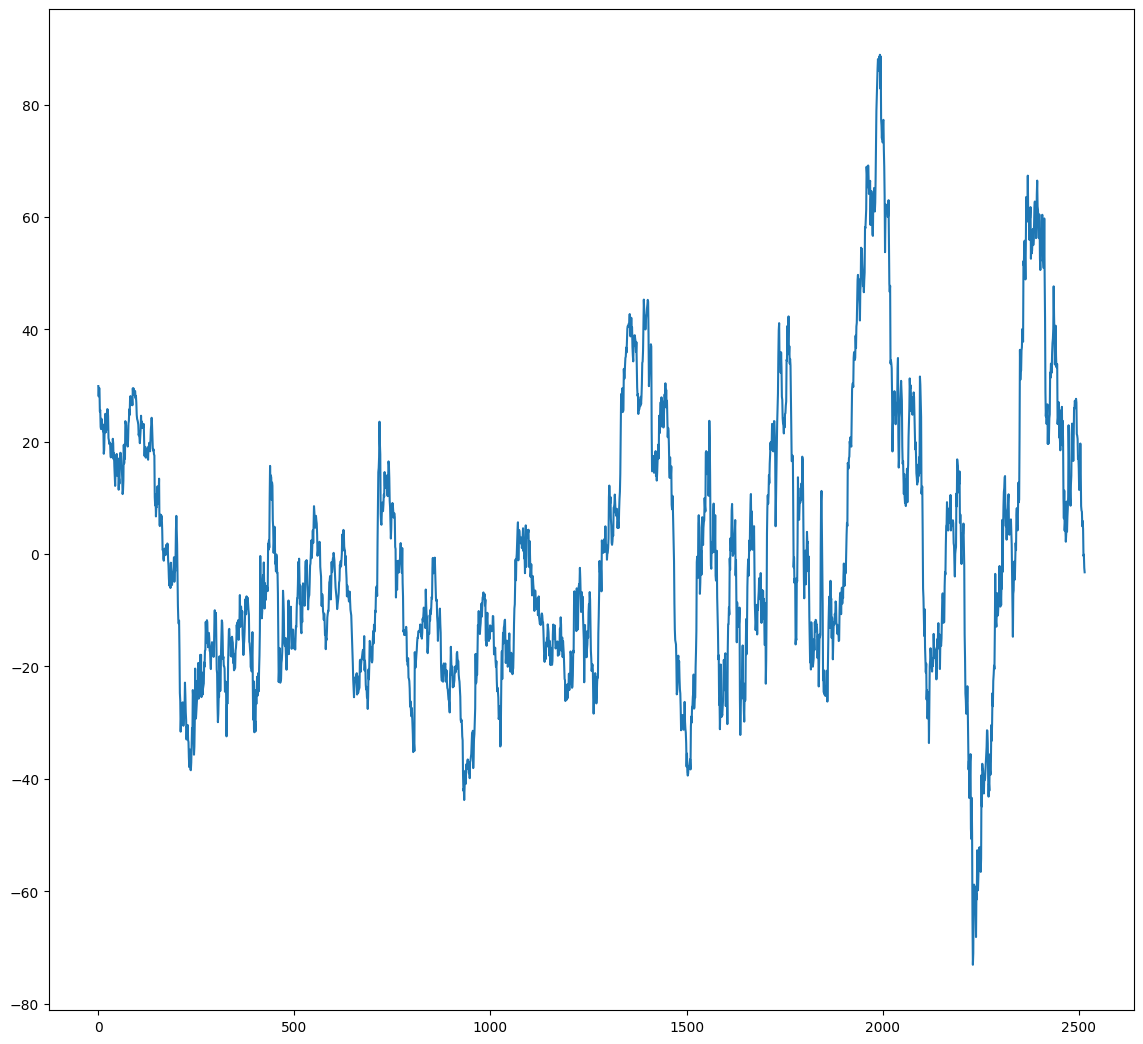

In [40]:
import os

def get_residuals(s1, s2):
    s1_df_path = os.path.join(DATA_BASE, s1 + '.pkl')
    s2_df_path = os.path.join(DATA_BASE, s2 + '.pkl')

    s1_df = pd.read_pickle(s1_df_path)
    s2_df = pd.read_pickle(s2_df_path)

    residuals = regression_residuals(s1_df, s2_df)
    return residuals


# get most cointegrated stocks
stack = heatmap_df.stack()
print(len(stack))

stack = stack.reset_index() \
             .sort_values(by=0) \
             .values.tolist()

for item in stack:
    print(item)

# good pairs: (AMGN, WBA), (AMGN, VOD)

residuals = get_residuals('AMGN', 'VOD')
plt.figure(figsize=(12, 9))
sns.lineplot(residuals)
plt.title("Cointegration of AMGN with VOD")
plt.show()

residuals = get_residuals('AMGN', 'VRSK')
plt.figure(figsize=(14, 13))
sns.lineplot(residuals)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                 2.450e+04
Date:                Sun, 17 Nov 2024   Prob (F-statistic):               0.00
Time:                        08:11:59   Log-Likelihood:                -10441.
No. Observations:                2516   AIC:                         2.089e+04
Df Residuals:                    2514   BIC:                         2.090e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         89.9734      0.612    147.048      0.0

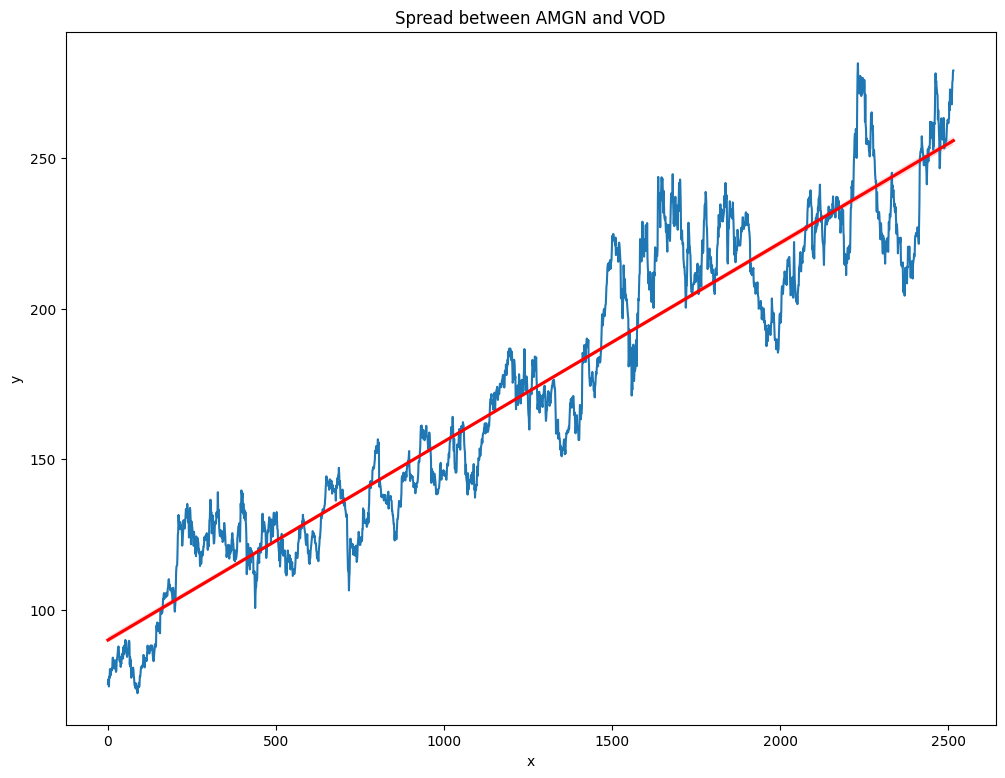

In [63]:
# Examine differences between spreads and residuals

amgn_df_path = os.path.join(DATA_BASE, 'AMGN.pkl')
amgn_df = pd.read_pickle(amgn_df_path)

vod_df_path = os.path.join(DATA_BASE, 'VOD.pkl')
vod_df = pd.read_pickle(vod_df_path)

spreads = amgn_df - vod_df

spread_df = pd.DataFrame({
    'x': range(len(spreads)),
    'y': spreads[0]
})

# spread_df['sma'] = spread_df['y'].rolling(window=180).mean()

# actually get regression outputs
x = spread_df['x']
y = spread_df['y']

x = sm.add_constant(x)
model = sm.OLS(y, x)
res = model.fit()

print(res.summary())

plt.figure(figsize=(12, 9))

sns.lineplot(data=spread_df, x='x', y='y')
# sns.lineplot(data=spread_df, x='x', y='sma')
sns.regplot(data=spread_df, x='x', y='y', line_kws={ 'color': 'red' }, scatter=False)

plt.title("Spread between AMGN and VOD")
plt.show()